# "Pump it Up: Data Mining the Water Table"

EDA

Jason & Tom

In [1]:
# Imports

import pandas as pd
import numpy as np

# Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Chi Square
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Test Train Split
from sklearn.model_selection import train_test_split

# Models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier

# Model Selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

# Balancing the dataset.
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

import wandb


/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 2.0.1-elementary11-ubuntu6.1.1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


# EDA

This notebook explains the steps we took while performing EDA on our cleaned dataset. Whilst EDA does technically include 'data cleaning', we took the initiative to place that in it's own notebook so that the steps we took are much clearer. This notebook will present our findings on the correlation between certain features, as well as feature selection / engineering.

We both took different steps to do this, and collated our findings at the end. Cells by one author only will contain ``` Written By [Author] ``` at the top. Cells without this tag were steps taken by both of us, unless specified.

In [17]:
df = pd.read_csv("./datasets/cleaned_water.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)

# 1 Feature Engineering

In [18]:
# From here: https://github.com/BrendaLoznik/waterpumps

df['recorded_year'] = pd.DatetimeIndex(df ['date_recorded']).year
df['age'] = df['recorded_year'] - df['construction_year']
df['age'] = df['age'].apply(lambda x: x if x < 100 else -1)
df = df.drop('recorded_year',axis=1)

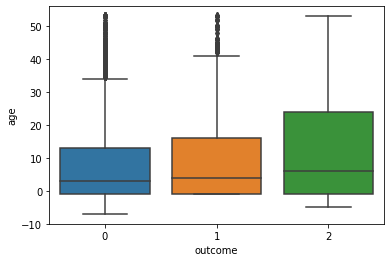

In [19]:
sns.boxplot(x='outcome', y='age', data=df)
plt.show()

In [20]:
# From here: https://github.com/BrendaLoznik/waterpumps

df['month'] = pd.DatetimeIndex(df['date_recorded']).month

# season encoder
# 1: 'short dry', 2: 'long rain', 3: 'long dry', 4: 'short rain'
season_mapper = {1: 1,2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3,
                 8: 3, 9: 3, 10: 3, 11: 4, 12: 4}
#.p feature values to scale
df['season']=df['month'].replace(season_mapper)
df=df.drop('month', axis=1)

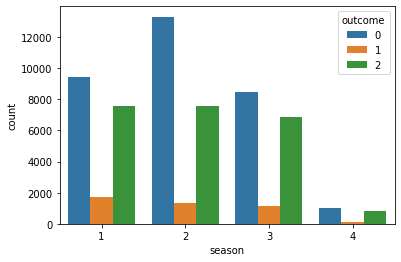

In [21]:
sns.countplot(x='season', hue='outcome', data=df)
plt.show()

In [22]:
# Author [Tom]

# quantity = 1 (enough) se to 1, everything else set to 0
df['consistent_water'] = np.where(df['quantity'] == 1, 1, 0)

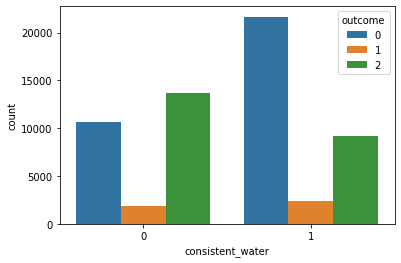

In [23]:
sns.countplot(x='consistent_water', hue='outcome', data=df)
plt.show()

In [24]:
# Author [Tom]

df['source_below_sea_level'] = np.where(df['gps_height'] < df['amount_tsh'], 1, 0)

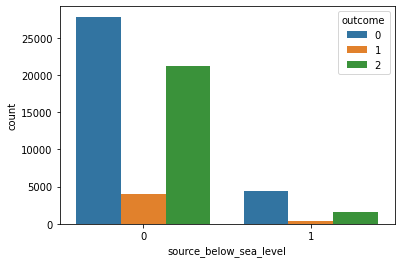

In [25]:
sns.countplot(x='source_below_sea_level', hue='outcome', data=df)
plt.show()

In [26]:
df.to_csv('./datasets/water_fe.csv')

# 2 Graphing

In [27]:
df = pd.read_csv('./datasets/water_fe.csv')
df.drop("Unnamed: 0", axis=1, inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 60 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           59400 non-null  int64  
 1   amount_tsh                   59400 non-null  float64
 2   date_recorded                59400 non-null  object 
 3   funder                       55765 non-null  object 
 4   gps_height                   59400 non-null  int64  
 5   installer                    55745 non-null  object 
 6   longitude                    59400 non-null  float64
 7   latitude                     59400 non-null  float64
 8   wpt_name                     59400 non-null  object 
 9   num_private                  59400 non-null  int64  
 10  basin                        59400 non-null  int64  
 11  subvillage                   59029 non-null  object 
 12  region                       59400 non-null  object 
 13  region_code     

## 2.1 Correlation Matrix

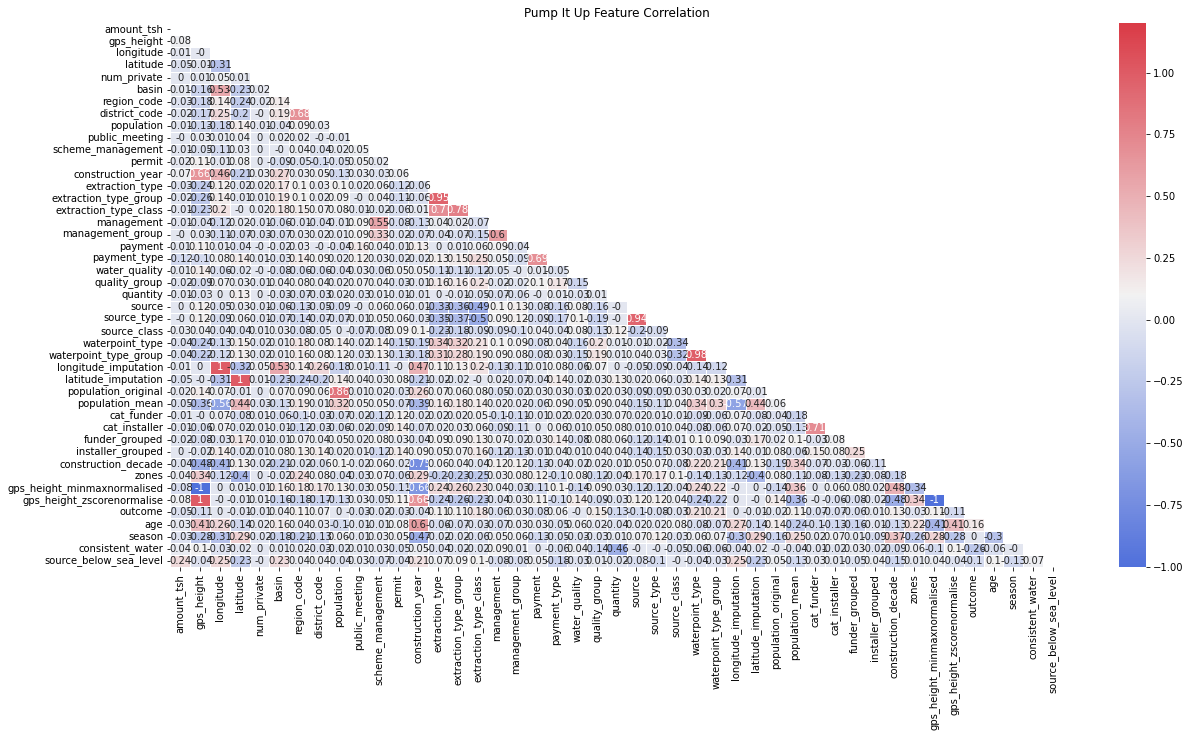

In [29]:
# Author [Jason]
# Code adapted from COMP 3009 Lab Sheet

feature = df.drop(columns=['id'])

corrMatt = feature.corr().round(2)

# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 10))
plt.title('Pump It Up Feature Correlation')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask,
ax=ax, annot=True, fmt='.2g', linewidths=1);

There's not many super highly correlated features.

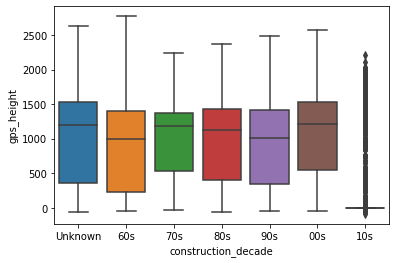

In [30]:
ax = sns.boxplot(data=df, x='construction_decade', y='gps_height')
ax.set_xticklabels(['Unknown', '60s', '70s', '80s', '90s', '00s', '10s'])
plt.show()

There doesn't seem to be a significant change in decade and gps_height.
Add more to here if we want to test out any other correlations between features.

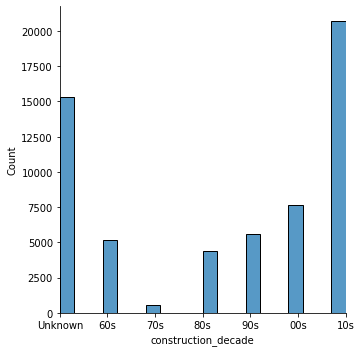

In [31]:
ax = sns.displot(data=df, x='construction_decade')
plt.xlim(0,6)
ax.set_xticklabels(['Unknown', '60s', '70s', '80s', '90s', '00s', '10s'])
plt.show()

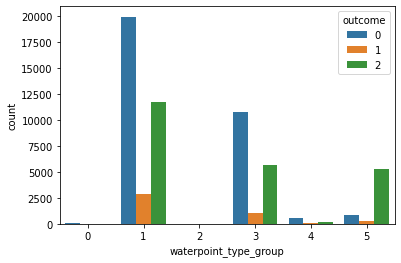

In [7]:
sns.countplot(x='waterpoint_type_group', hue='outcome', data=df)
plt.show()

Here, we can see that waterpoint_type_group 5 has a lot more of category 2, although this could be due to limited data.

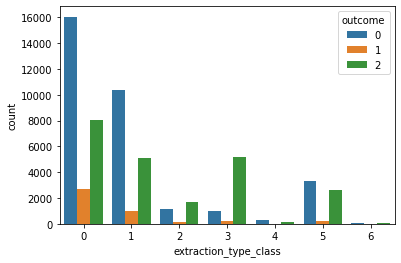

In [8]:
sns.countplot(x='extraction_type_class', hue='outcome', data=df)
plt.show()

Again, we can see that certain classes of extraction types are more likely to be of category 2.

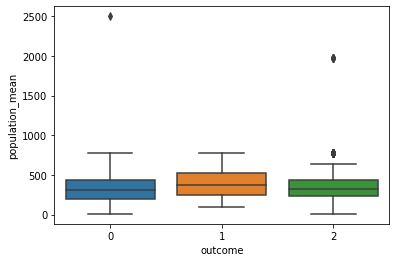

In [9]:
sns.boxplot(x='outcome', y='population_mean', data=df)
plt.show()

It's not crazy significant, but faulty wells usually have a larger population.

# 3 Feature Importance

## 3.1 Random Forest

In [35]:
classification_target = df['outcome']

clean_feature = feature.drop(columns = ['date_recorded', 'wpt_name','num_private','subvillage','region_code','district_code','lga','ward','recorded_by',
                            'scheme_name','extraction_type_group','payment','quality_group','quantity_group',
                            'source','waterpoint_type','status_group','construction_year','region','funder','installer', 'outcome',
                            'installer_clean', 'funder_clean'])

In [37]:
# Author [Jason]
X_train, X_test, y_train, y_test = train_test_split(clean_feature,classification_target, test_size=0.2, random_state=42, stratify=classification_target)
rf = RandomForestClassifier(n_estimators=120,class_weight="balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=120)

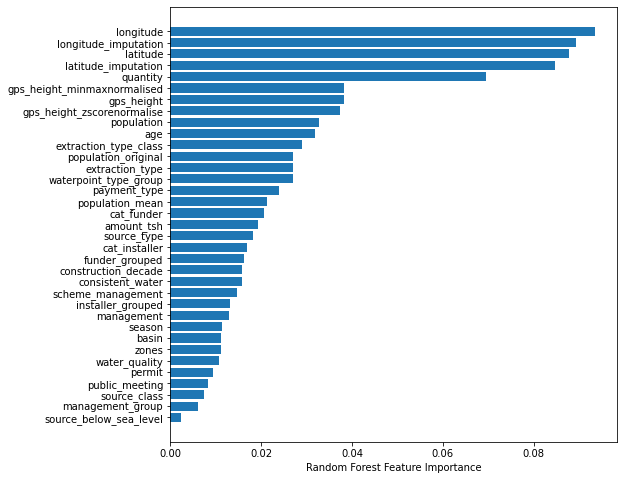

In [38]:
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(8,8))
plt.barh(clean_feature.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

## Chi Square Tests

In [39]:
classification_target = df['outcome']
categorical_features = df[['basin','public_meeting','scheme_management','permit','extraction_type_class','management','management_group','payment_type','water_quality','quantity','source_type',
                                     'source_class','waterpoint_type_group','cat_funder','cat_installer','funder_grouped','installer_grouped','construction_decade','zones','season','consistent_water','source_below_sea_level']]

In [40]:
# Author [Jason]

# Select the top 10 best categorical features
categorical_features = SelectKBest(chi2, k=10).fit(categorical_features, classification_target)

# Convert the selected clinical feature's header name into a list
categorical_features_list = list(categorical_features.get_feature_names_out())
print(categorical_features_list)

['extraction_type_class', 'payment_type', 'quantity', 'source_type', 'source_class', 'waterpoint_type_group', 'cat_funder', 'construction_decade', 'consistent_water', 'source_below_sea_level']


## More Feature Selection

In [95]:
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel, RFE
from time import time

In [89]:
features = df.drop(['outcome', 'funder', 'installer',
                    'wpt_name', 'subvillage', 'region',
                    'lga', 'ward', 'recorded_by', 'scheme_name',
                    'extraction_type_group', 'payment', 'quality_group',
                    'quantity_group', 'source', 'waterpoint_type',
                    'status_group', 'date_recorded'], axis=1)
target = df['outcome']

In [92]:
feature_names = features.columns
clf_xgb = XGBClassifier(random_state=42)
clf_xgb.fit(features, target)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

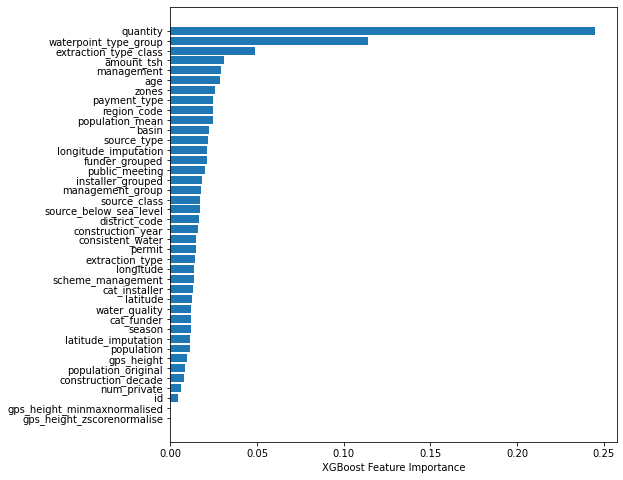

In [103]:
sorted_idx = clf_xgb.feature_importances_.argsort()
plt.figure(figsize=(8,8))
plt.barh(features.columns[sorted_idx], clf_xgb.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.show()

In [104]:
model = SelectFromModel(clf_xgb, prefit=True)
cols_idxs = model.get_support(indices=True)
new_features = features.iloc[:, cols_idxs]
new_features

,amount_tsh,extraction_type_class,management,quantity,waterpoint_type_group,zones,age
0,6000.0,0,7,1,1,4,12
1,0.0,0,11,2,1,2,3
2,25.0,0,7,1,1,3,4
3,0.0,5,7,0,1,5,27
4,0.0,0,1,3,1,2,-1
...,...,...,...,...,...,...,...
59395,10.0,0,9,1,1,3,14
59396,4700.0,0,7,1,1,4,15
59397,0.0,1,7,1,3,4,-1
59398,0.0,1,7,2,3,0,-1


In [ ]:
# This takes too long to run ....
tic_fwd = time()
sfs_forward = SequentialFeatureSelector(
    clf_xgb, n_features_to_select='auto', direction='forward', tol=0.05
).fit(features, target)
toc_fwd = time()

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    clf_xgb, n_features_to_select='auto', direction='backward', tol=0.05
).fit(features, target)
toc_bwd = time()

print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

In [ ]:
# This also takes a long time to run..

rfe = RFE(estimator=clf_xgb, n_features_to_select=0.75)
rfe.fit(features, target)
print(rfe.support_)
print(rfe.ranking_)

**Splitting into test/train**

In [8]:
# This is not the final feature selection, it is just the first iteration of the process.

features = df[['extraction_type', 'payment_type', 'quantity', 'source_type',
                         'waterpoint_type_group', 'cat_funder', 'construction_decade', 'consistent_water',
                         'age', 'season', 'water_quality', 'cat_installer', 'gps_height_zscorenormalise',
                         'population', 'zones','source_below_sea_level']]
target = df['outcome']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

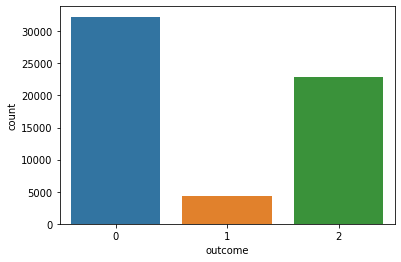

In [10]:
sns.countplot(x='outcome', data=df)
plt.show()

Imbalanced dataset unfortunately, we will have to deal with this.

# Modelling

### Model Overview

In [19]:
models = [
    HistGradientBoostingClassifier(random_state=42),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    xgb.XGBClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    CatBoostClassifier(random_state=42)
]

names = ['HistGradientBoosting', 'KNN', 'DT', 'XGB',
         'Bagging', 'CatBoost']

acc = []
prec = []
rec = []

for model in models:
    print(model)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    acc.append(accuracy_score(y_test, preds))
    prec.append(precision_score(y_test, preds, average="macro"))
    rec.append(recall_score(y_test, preds, average="macro"))


HistGradientBoostingClassifier(random_state=42)
KNeighborsClassifier()
DecisionTreeClassifier(random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42,
              reg_alpha=None, reg_lambda=None, ...)
BaggingClassifier(random_state=42)
Learning rate set to 0.096348
0:	learn: 1.0318441	total: 77.6ms	remaining: 1m 17s
1:	learn: 0.9798068	total: 93.5ms

153:	learn: 0.5750298	total: 2.24s	remaining: 12.3s
154:	learn: 0.5745786	total: 2.26s	remaining: 12.3s
155:	learn: 0.5739943	total: 2.28s	remaining: 12.3s
156:	learn: 0.5737936	total: 2.29s	remaining: 12.3s
157:	learn: 0.5733173	total: 2.3s	remaining: 12.3s
158:	learn: 0.5730783	total: 2.31s	remaining: 12.2s
159:	learn: 0.5727087	total: 2.33s	remaining: 12.2s
160:	learn: 0.5724461	total: 2.34s	remaining: 12.2s
161:	learn: 0.5720239	total: 2.35s	remaining: 12.2s
162:	learn: 0.5717188	total: 2.37s	remaining: 12.2s
163:	learn: 0.5712407	total: 2.38s	remaining: 12.1s
164:	learn: 0.5708191	total: 2.39s	remaining: 12.1s
165:	learn: 0.5704348	total: 2.4s	remaining: 12.1s
166:	learn: 0.5701021	total: 2.42s	remaining: 12.1s
167:	learn: 0.5695346	total: 2.43s	remaining: 12s
168:	learn: 0.5692142	total: 2.44s	remaining: 12s
169:	learn: 0.5687271	total: 2.46s	remaining: 12s
170:	learn: 0.5685819	total: 2.47s	remaining: 12s
171:	learn: 0.5683076	total: 2.49s	remaining: 12s
172:	learn: 0.5680881	to

316:	learn: 0.5354473	total: 4.54s	remaining: 9.79s
317:	learn: 0.5353064	total: 4.56s	remaining: 9.77s
318:	learn: 0.5350804	total: 4.58s	remaining: 9.77s
319:	learn: 0.5349532	total: 4.59s	remaining: 9.75s
320:	learn: 0.5346611	total: 4.6s	remaining: 9.73s
321:	learn: 0.5344791	total: 4.61s	remaining: 9.71s
322:	learn: 0.5341892	total: 4.63s	remaining: 9.69s
323:	learn: 0.5340476	total: 4.64s	remaining: 9.67s
324:	learn: 0.5338669	total: 4.65s	remaining: 9.65s
325:	learn: 0.5337016	total: 4.66s	remaining: 9.63s
326:	learn: 0.5335407	total: 4.67s	remaining: 9.62s
327:	learn: 0.5334216	total: 4.68s	remaining: 9.6s
328:	learn: 0.5331342	total: 4.7s	remaining: 9.58s
329:	learn: 0.5330720	total: 4.71s	remaining: 9.56s
330:	learn: 0.5328760	total: 4.72s	remaining: 9.54s
331:	learn: 0.5327203	total: 4.73s	remaining: 9.52s
332:	learn: 0.5325099	total: 4.75s	remaining: 9.51s
333:	learn: 0.5322874	total: 4.77s	remaining: 9.51s
334:	learn: 0.5321344	total: 4.78s	remaining: 9.49s
335:	learn: 0.5

478:	learn: 0.5129062	total: 6.83s	remaining: 7.43s
479:	learn: 0.5127231	total: 6.84s	remaining: 7.41s
480:	learn: 0.5125302	total: 6.86s	remaining: 7.4s
481:	learn: 0.5123738	total: 6.87s	remaining: 7.38s
482:	learn: 0.5122750	total: 6.88s	remaining: 7.37s
483:	learn: 0.5121308	total: 6.9s	remaining: 7.35s
484:	learn: 0.5120308	total: 6.91s	remaining: 7.34s
485:	learn: 0.5118978	total: 6.92s	remaining: 7.32s
486:	learn: 0.5118380	total: 6.94s	remaining: 7.31s
487:	learn: 0.5117761	total: 6.95s	remaining: 7.29s
488:	learn: 0.5116834	total: 6.96s	remaining: 7.27s
489:	learn: 0.5115630	total: 6.97s	remaining: 7.26s
490:	learn: 0.5114469	total: 6.99s	remaining: 7.24s
491:	learn: 0.5112718	total: 7s	remaining: 7.23s
492:	learn: 0.5111911	total: 7.01s	remaining: 7.21s
493:	learn: 0.5110854	total: 7.02s	remaining: 7.19s
494:	learn: 0.5110264	total: 7.04s	remaining: 7.18s
495:	learn: 0.5109439	total: 7.05s	remaining: 7.17s
496:	learn: 0.5108610	total: 7.07s	remaining: 7.15s
497:	learn: 0.510

637:	learn: 0.4955696	total: 8.92s	remaining: 5.06s
638:	learn: 0.4954659	total: 8.94s	remaining: 5.05s
639:	learn: 0.4953740	total: 8.95s	remaining: 5.03s
640:	learn: 0.4952910	total: 8.97s	remaining: 5.02s
641:	learn: 0.4952497	total: 8.98s	remaining: 5.01s
642:	learn: 0.4951939	total: 8.99s	remaining: 4.99s
643:	learn: 0.4951356	total: 9s	remaining: 4.97s
644:	learn: 0.4950536	total: 9.01s	remaining: 4.96s
645:	learn: 0.4949096	total: 9.03s	remaining: 4.95s
646:	learn: 0.4947767	total: 9.04s	remaining: 4.93s
647:	learn: 0.4947223	total: 9.05s	remaining: 4.92s
648:	learn: 0.4946283	total: 9.06s	remaining: 4.9s
649:	learn: 0.4944737	total: 9.08s	remaining: 4.89s
650:	learn: 0.4943780	total: 9.09s	remaining: 4.87s
651:	learn: 0.4942223	total: 9.1s	remaining: 4.86s
652:	learn: 0.4940487	total: 9.11s	remaining: 4.84s
653:	learn: 0.4939056	total: 9.13s	remaining: 4.83s
654:	learn: 0.4937965	total: 9.15s	remaining: 4.82s
655:	learn: 0.4937538	total: 9.16s	remaining: 4.8s
656:	learn: 0.4936

811:	learn: 0.4804411	total: 11.2s	remaining: 2.59s
812:	learn: 0.4803963	total: 11.2s	remaining: 2.58s
813:	learn: 0.4803067	total: 11.2s	remaining: 2.56s
814:	learn: 0.4802500	total: 11.2s	remaining: 2.55s
815:	learn: 0.4801397	total: 11.3s	remaining: 2.54s
816:	learn: 0.4800608	total: 11.3s	remaining: 2.52s
817:	learn: 0.4799851	total: 11.3s	remaining: 2.51s
818:	learn: 0.4799571	total: 11.3s	remaining: 2.5s
819:	learn: 0.4799025	total: 11.3s	remaining: 2.48s
820:	learn: 0.4798573	total: 11.3s	remaining: 2.47s
821:	learn: 0.4797576	total: 11.3s	remaining: 2.45s
822:	learn: 0.4796231	total: 11.3s	remaining: 2.44s
823:	learn: 0.4795075	total: 11.4s	remaining: 2.42s
824:	learn: 0.4794302	total: 11.4s	remaining: 2.41s
825:	learn: 0.4793642	total: 11.4s	remaining: 2.4s
826:	learn: 0.4792749	total: 11.4s	remaining: 2.38s
827:	learn: 0.4792225	total: 11.4s	remaining: 2.37s
828:	learn: 0.4791110	total: 11.4s	remaining: 2.36s
829:	learn: 0.4790766	total: 11.4s	remaining: 2.34s
830:	learn: 0.

983:	learn: 0.4670868	total: 13.5s	remaining: 219ms
984:	learn: 0.4670489	total: 13.5s	remaining: 206ms
985:	learn: 0.4669740	total: 13.5s	remaining: 192ms
986:	learn: 0.4669125	total: 13.5s	remaining: 178ms
987:	learn: 0.4668680	total: 13.5s	remaining: 165ms
988:	learn: 0.4668015	total: 13.6s	remaining: 151ms
989:	learn: 0.4667179	total: 13.6s	remaining: 137ms
990:	learn: 0.4666414	total: 13.6s	remaining: 123ms
991:	learn: 0.4665847	total: 13.6s	remaining: 110ms
992:	learn: 0.4664636	total: 13.6s	remaining: 95.9ms
993:	learn: 0.4663927	total: 13.6s	remaining: 82.2ms
994:	learn: 0.4662981	total: 13.6s	remaining: 68.5ms
995:	learn: 0.4662336	total: 13.6s	remaining: 54.8ms
996:	learn: 0.4662001	total: 13.7s	remaining: 41.1ms
997:	learn: 0.4661509	total: 13.7s	remaining: 27.4ms
998:	learn: 0.4660796	total: 13.7s	remaining: 13.7ms
999:	learn: 0.4660120	total: 13.7s	remaining: 0us


In [25]:
df = pd.DataFrame({'Model': names, 'Acc': acc, 'Precision': prec, 'Recall': rec})
df.sort_values('Acc', ascending=False)

,Model,Acc,Precision,Recall
5,CatBoost,0.779882,0.723913,0.609056
3,XGB,0.779125,0.728705,0.600341
0,HistGradientBoosting,0.775758,0.733996,0.597320
4,Bagging,0.773148,0.684448,0.629946
2,DT,0.742256,0.623670,0.610786
1,KNN,0.697643,0.599372,0.540756


So our best options are:

    - HistGradientBoost
    - XGB
    - Bagging
    - CatBoost

In [ ]:
def run_classifier(clf, X, y,  X_test, y_test):
    scores = cross_val_score(clf, X, y, cv=5)
    print("Cross-Val")
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    print("--------------------------------------")
    clf.fit(X, y)
    preds = clf.predict(X_test)
    print("1 fit")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds, average='macro'))
    print("Recall:", recall_score(y_test, preds, average='macro'))
    cmap = sns.diverging_palette(260, 10, as_cmap=True)
    sns.heatmap(confusion_matrix(y_test, preds), cmap=cmap, annot=True)
    plt.show()
    

### HistGradientBoost

Cross-Val
0.78 accuracy with a standard deviation of 0.00
--------------------------------------
1 fit
Accuracy: 0.7757575757575758
Precision: 0.7339955847712344
Recall: 0.5973203055833515


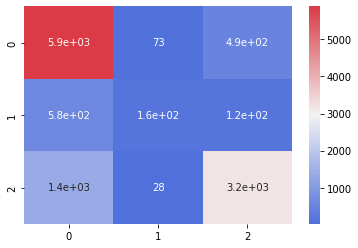

In [37]:
clf_hgb = HistGradientBoostingClassifier(random_state=42)
run_classifier(clf_hgb, X_train, y_train, X_test, y_test)

Yeh, as we can see here, it's really good at 0 <-> 0, decent at 2 <-> 2, but terrible at 1 <-> 1. Definitely needs to be balanced. When the actual class is 1, it's more likely to be predicted as 0.

The row is y_true, the column is y_pred

### XGBoost

In [30]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

Cross-Val
0.78 accuracy with a standard deviation of 0.00
--------------------------------------
1 fit
Accuracy: 0.7791245791245791
Precision: 0.7287052435332378
Recall: 0.6003407158856965


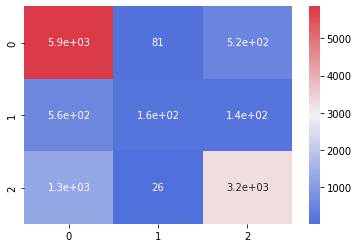

In [38]:
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'merror',
    'seed': 0
}
clf_xgb = xgb.XGBClassifier(**params)

run_classifier(clf_xgb, X_train, y_train, X_test, y_test)

Accuracy: 0.7095959595959596
Precision: 0.6287181070757087
Recall: 0.6947827819531115


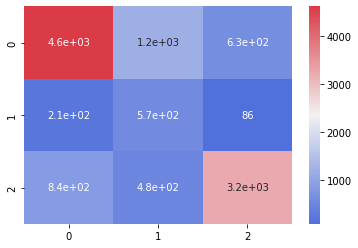

In [33]:
clf_xgb = xgb.XGBClassifier(**params)
# We are using 'class_weight' == 'balanced' here, which results in improved recall, worse accuracy.
clf_xgb.fit(X_train, y_train, sample_weight=sample_weights)
preds = clf_xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))
print("Precision:", precision_score(y_test, preds, average='macro'))
print("Recall:", recall_score(y_test, preds, average='macro'))
cmap = sns.diverging_palette(260, 10, as_cmap=True)
sns.heatmap(confusion_matrix(y_test, preds), cmap=cmap, annot=True)
plt.show()

So when we balance the weights directly in XGBoost, the accuracy drops by 8%.

### CatBoost

Cross-Val
0.71 accuracy with a standard deviation of 0.01
--------------------------------------
1 fit
Accuracy: 0.7128787878787879
Precision: 0.6329387163535719
Recall: 0.7046710907663479


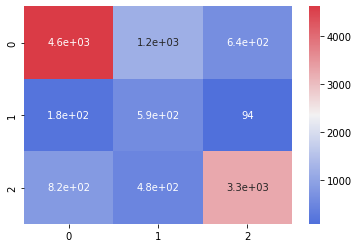

In [39]:
clf_cb = CatBoostClassifier(random_state=42, verbose=0, auto_class_weights="Balanced")
run_classifier(clf_cb, X_train, y_train, X_test, y_test)

The recall here is really good. Perhaps we can use this without balancing the dataset.

### BaggingClassifier

Cross-Val
0.77 accuracy with a standard deviation of 0.00
--------------------------------------
1 fit
Accuracy: 0.7731481481481481
Precision: 0.6844481999457512
Recall: 0.6299460301311426


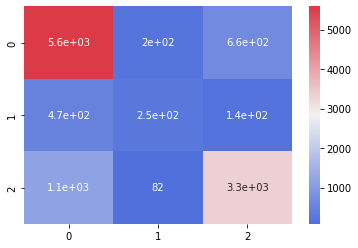

In [40]:
clf_bagging = BaggingClassifier(random_state=42)
run_classifier(clf_bagging, X_train, y_train, X_test, y_test)

## Balancing The Dataset

As we can see from the previous tests in model building, the fact that the dataset is unbalanced means we really struggle to accurately predict the 1 <-> 1 class. We can try to balance this using SMOTE-ENN. We will only rebalanced the train set, as we can then use Ensemble methods, where some models are trained on the balanced dataset and some are not.

In [19]:
sm = SMOTE(random_state=42, k_neighbors=12, sampling_strategy='minority')
enn = EditedNearestNeighbours(sampling_strategy=[1])

In [20]:
sme = SMOTEENN(random_state=42, smote=sm, enn=enn)
X_res, y_res = sme.fit_resample(X_train, y_train)

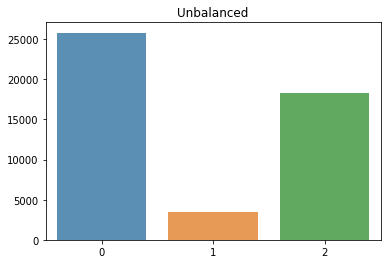

In [21]:
y_train_count = y_train.value_counts()
sns.barplot(x=y_train_count.index, y=y_train_count.values, alpha=0.8)
plt.title("Unbalanced")
plt.show()

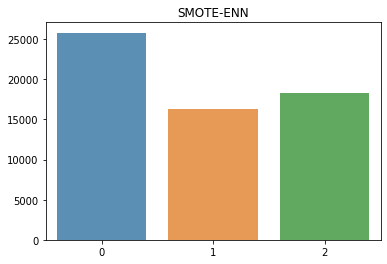

In [22]:
y_res_count = y_res.value_counts()
sns.barplot(x=y_res_count.index, y=y_res_count.values, alpha=0.8)
plt.title("SMOTE-ENN")
plt.show()

### Testing Models on the Balanced Dataset

**XGBoost**

Cross-Val
0.84 accuracy with a standard deviation of 0.02
--------------------------------------
1 fit
Accuracy: 0.7808080808080808
Precision: 0.6826653570947826
Recall: 0.6244887720500114


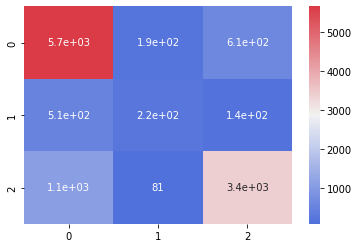

In [41]:
clf_xgb = xgb.XGBClassifier(random_state=42)
run_classifier(clf_xgb, X_res, y_res, X_test, y_test)

**CatBoost**

Cross-Val
0.81 accuracy with a standard deviation of 0.02
--------------------------------------
1 fit
Accuracy: 0.7574074074074074
Precision: 0.6431045147188654
Recall: 0.6487816015647421


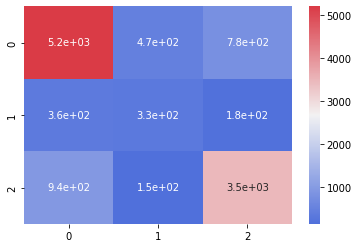

In [42]:
clf_cb = CatBoostClassifier(random_state=42, verbose=0, auto_class_weights="Balanced")
run_classifier(clf_cb, X_res, y_res, X_test, y_test)

We can set auto_class_weights to "Balanced" to increase recall but drop accuracy !

**HistGradientBoost**

Cross-Val
0.81 accuracy with a standard deviation of 0.02
--------------------------------------
1 fit
Accuracy: 0.7651515151515151
Precision: 0.6649390165348811
Recall: 0.6269602279973537


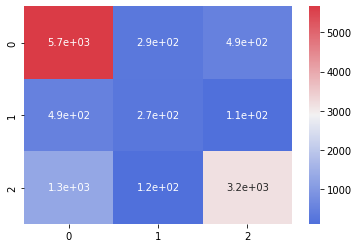

In [43]:
clf_hgb = HistGradientBoostingClassifier(random_state=42)
run_classifiersifier(clf_hgb, X_res, y_res, X_test, y_test)

**Bagging Classifier**

Cross-Val
0.82 accuracy with a standard deviation of 0.02
--------------------------------------
1 fit
Accuracy: 0.768013468013468
Precision: 0.6550489081108363
Recall: 0.6233063091489169


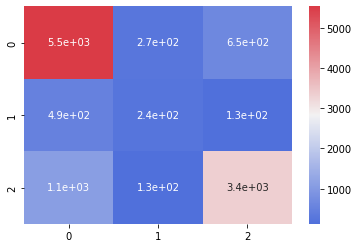

In [44]:
clf_bagging = BaggingClassifier(random_state=42)
run_classifier(clf_bagging, X_res, y_res, X_test, y_test)

## Hyper-parameter Searching

(Tom)

I will be performing hyper-parameter tuning on the (un)balanced dataset to see if we can see any improvements.

The order of tuning is:

    - Tune for 'recall_macro'
        - On Balanced Dataset
        - On UnBalanced Dataset
    - Tune for 'accuracy'
        - On Balanced Dataset
        - On UnBalanced Dataset

In [11]:
def display_results(rcv):
    print("Best Params:", rcv.best_params_)
    print("Best Estiamtor:", rcv.best_estimator_)
    print("Best Score:", rcv.best_score_)
    
    preds = rcv.best_estimator_.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds, average='macro'))
    print("Recall:", recall_score(y_test, preds, average='macro'))

    print(classification_report(y_test, preds))

    cmap = sns.diverging_palette(260, 10, as_cmap=True)
    sns.heatmap(confusion_matrix(y_test, preds), cmap=cmap, annot=True)
    plt.show()

### Tuning on the Balanced Dataset

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

In [43]:
def run_random_cv(estimator, hps, scoring, X, y):
    random_cv = RandomizedSearchCV(estimator=estimator,
                                   param_distributions=hps,
                                   cv=3, n_iter=25,
                                   scoring=scoring,
                                   verbose=1,
                                   return_train_score=True,
                                   random_state=42)
    random_cv.fit(X, y)
    print("-----------------------------------------")
    print("Best Params:", random_cv.best_params_)
    print("Best Score:", random_cv.best_score_)
    print("-----------------------------------------")
    preds = random_cv.best_estimator_.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds, average='macro'))
    print("Recall:", recall_score(y_test, preds, average='macro'))

    print(classification_report(y_test, preds))

    cmap = sns.diverging_palette(260, 10, as_cmap=True)
    sns.heatmap(confusion_matrix(y_test, preds), cmap=cmap, annot=True)
    plt.show()
    

**XGBoost**

In [39]:
xgb_hps = {
        'max_depth': [3, 6, 9],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 1e-5, 1e-3, 1e-1, 1,1e2],
        'reg_lambda': [0, 1e-5, 1e-3, 1e-1, 1, 1e2],
        'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.3],
        'n_estimators': [50, 100, 150, 200],
        'min_child_weight': [0, 0.2, 0.4, 0.6, 0.8, 1],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.5, 0.7, 0.9, 1],
}
clf_xgb = XGBClassifier()

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'subsample': 0.8, 'reg_lambda': 1e-05, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1}
Best Score: 0.8340838798131561
-----------------------------------------
Accuracy: 0.7808080808080808
Precision: 0.6826653570947826
Recall: 0.6244887720500114
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      6452
           1       0.45      0.25      0.32       863
           2       0.82      0.75      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.68      0.62      0.64     11880
weighted avg       0.77      0.78      0.77     11880



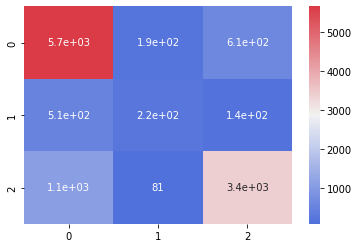

In [45]:
run_random_cv(estimator=clf_xgb, hps=xgb_hps, scoring='recall_macro', X=X_res, y=y_res)

**CatBoost**

In [40]:
cb_hps = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.03, 0.1, 0.3],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'random_strength':[0, 1, 5, 10],
    'border_count': [32, 64, 128],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    'verbose': [0]
}
clf_cb = CatBoostClassifier()

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'verbose': 0, 'random_strength': 10, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 8, 'border_count': 32, 'bagging_temperature': 1.0}
Best Score: 0.8309535182463974
-----------------------------------------
Accuracy: 0.7790404040404041
Precision: 0.6739441076323894
Recall: 0.6297609341654038
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      6452
           1       0.43      0.27      0.33       863
           2       0.81      0.76      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.67      0.63      0.65     11880
weighted avg       0.77      0.78      0.77     11880



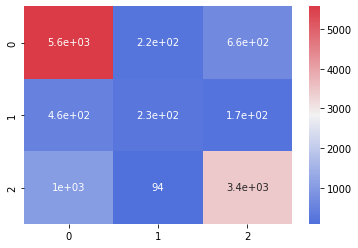

In [46]:
run_random_cv(estimator=clf_cb, hps=cb_hps, scoring='recall_macro', X=X_res, y=y_res)

**HistGradientBoost**

In [33]:
hgb_hps = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [250, 750],
    'max_depth': [2, 4, 6, 8],
    'min_samples_leaf': [1, 5, 10],
    'max_leaf_nodes': [None, 4, 8, 12],
    'l2_regularization': [0.0, 0.1, 0.5, 1.0],
    'max_bins': [64, 128, 255],
    'early_stopping': [False, 'auto'],
    'validation_fraction': [0.1, 0.2],
    'n_iter_no_change': [5, 10, 20],
}
clf_hgb = HistGradientBoostingClassifier()

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'validation_fraction': 0.1, 'n_iter_no_change': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_iter': 750, 'max_depth': 8, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 1.0, 'early_stopping': False}
Best Score: 0.832020525737014
-----------------------------------------
Accuracy: 0.7817340067340067
Precision: 0.6828387101661256
Recall: 0.6308518473945441
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      6452
           1       0.44      0.27      0.34       863
           2       0.83      0.74      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.68      0.63      0.65     11880
weighted avg       0.77      0.78      0.77     11880



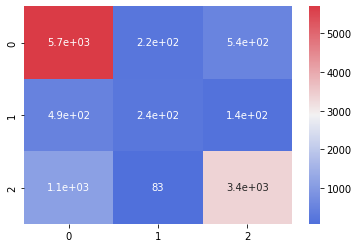

In [47]:
run_random_cv(estimator=clf_hgb, hps=hgb_hps, scoring='recall_macro', X=X_res, y=y_res)

**BaggingClassifier**

In [36]:
bc_hps = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'warm_start': [True, False],
    'n_jobs': [-1]
}
clf_bc = BaggingClassifier()

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': True}
Best Score: 0.8380388340328282
-----------------------------------------
Accuracy: 0.7818181818181819
Precision: 0.6796715326191115
Recall: 0.6315797894441343
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      6452
           1       0.43      0.28      0.33       863
           2       0.83      0.74      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.68      0.63      0.65     11880
weighted avg       0.77      0.78      0.77     11880



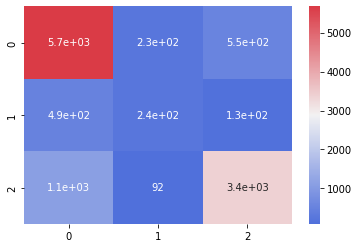

In [48]:
run_random_cv(estimator=clf_bc, hps=bc_hps, scoring='recall_macro', X=X_res, y=y_res)

### Tuning on the unbalanced dataset

**XGBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'subsample': 0.8, 'reg_lambda': 1e-05, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1}
Best Score: 0.6325379115815126
-----------------------------------------
Accuracy: 0.7837542087542088
Precision: 0.69421897411529
Recall: 0.627927179037906
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      6452
           1       0.48      0.25      0.33       863
           2       0.81      0.76      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.69      0.63      0.65     11880
weighted avg       0.77      0.78      0.77     11880



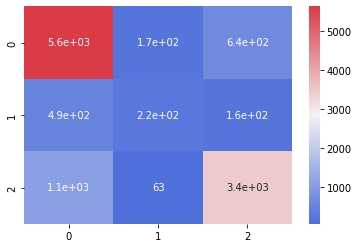

In [50]:
run_random_cv(estimator=clf_xgb, hps=xgb_hps, scoring='recall_macro', X=X_train, y=y_train)

**CatBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'verbose': 0, 'random_strength': 10, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 8, 'border_count': 32, 'bagging_temperature': 1.0}
Best Score: 0.6353073724227817
-----------------------------------------
Accuracy: 0.7801346801346801
Precision: 0.6893581506676746
Recall: 0.6333441617531982
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      6452
           1       0.48      0.28      0.35       863
           2       0.80      0.76      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.69      0.63      0.65     11880
weighted avg       0.77      0.78      0.77     11880



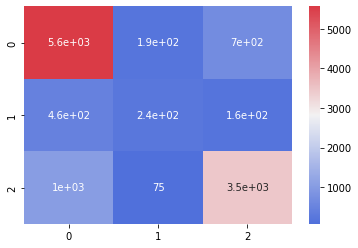

In [51]:
run_random_cv(estimator=clf_cb, hps=cb_hps, scoring='recall_macro', X=X_train, y=y_train)

**HistGradientBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'validation_fraction': 0.1, 'n_iter_no_change': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_iter': 750, 'max_depth': 8, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 1.0, 'early_stopping': False}
Best Score: 0.6318738583789972
-----------------------------------------
Accuracy: 0.7867845117845118
Precision: 0.7085871939829652
Recall: 0.6311610522675023
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      6452
           1       0.52      0.26      0.35       863
           2       0.83      0.74      0.78      4565

    accuracy                           0.79     11880
   macro avg       0.71      0.63      0.65     11880
weighted avg       0.78      0.79      0.78     11880



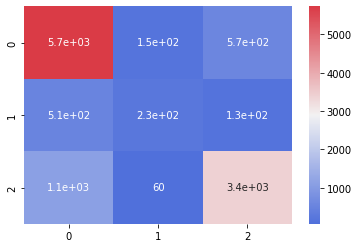

In [53]:
run_random_cv(estimator=clf_hgb, hps=hgb_hps, scoring='recall_macro', X=X_train, y=y_train)

**BaggingClassifier**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap_features': False, 'bootstrap': False}
Best Score: 0.6290135314191078
-----------------------------------------
Accuracy: 0.7856902356902357
Precision: 0.6993400604935004
Recall: 0.6352661228812059
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      6452
           1       0.50      0.27      0.35       863
           2       0.81      0.76      0.78      4565

    accuracy                           0.79     11880
   macro avg       0.70      0.64      0.66     11880
weighted avg       0.78      0.79      0.78     11880



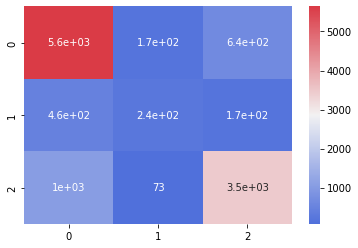

In [55]:
run_random_cv(estimator=clf_bc, hps=bc_hps, scoring='recall_macro', X=X_train, y=y_train)

### Tuning for accuracy

### Balanced Dataset

**XGBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'subsample': 0.8, 'reg_lambda': 1e-05, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1}
Best Score: 0.8355404242826389
-----------------------------------------
Accuracy: 0.7808080808080808
Precision: 0.6826653570947826
Recall: 0.6244887720500114
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      6452
           1       0.45      0.25      0.32       863
           2       0.82      0.75      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.68      0.62      0.64     11880
weighted avg       0.77      0.78      0.77     11880



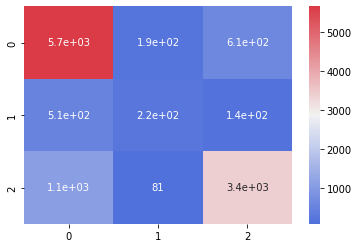

In [56]:
run_random_cv(estimator=clf_xgb, hps=xgb_hps, scoring='accuracy', X=X_res, y=y_res)

**CatBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'verbose': 0, 'random_strength': 10, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 8, 'border_count': 32, 'bagging_temperature': 1.0}
Best Score: 0.8316341920885585
-----------------------------------------
Accuracy: 0.7790404040404041
Precision: 0.6739441076323894
Recall: 0.6297609341654038
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      6452
           1       0.43      0.27      0.33       863
           2       0.81      0.76      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.67      0.63      0.65     11880
weighted avg       0.77      0.78      0.77     11880



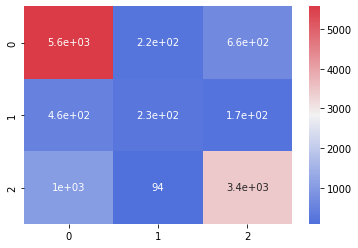

In [57]:
run_random_cv(estimator=clf_cb, hps=cb_hps, scoring='accuracy', X=X_res, y=y_res)

**HistGradientBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'validation_fraction': 0.1, 'n_iter_no_change': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_iter': 750, 'max_depth': 8, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 1.0, 'early_stopping': False}
Best Score: 0.8345969655956814
-----------------------------------------
Accuracy: 0.7817340067340067
Precision: 0.6828387101661256
Recall: 0.6308518473945441
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      6452
           1       0.44      0.27      0.34       863
           2       0.83      0.74      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.68      0.63      0.65     11880
weighted avg       0.77      0.78      0.77     11880



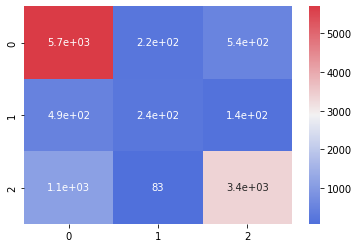

In [58]:
run_random_cv(estimator=clf_hgb, hps=hgb_hps, scoring='accuracy', X=X_res, y=y_res)

**Bagging Classifier**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': True}
Best Score: 0.8406714477165176
-----------------------------------------
Accuracy: 0.7815656565656566
Precision: 0.681360861035992
Recall: 0.6320939706442472
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      6452
           1       0.43      0.28      0.34       863
           2       0.83      0.74      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.68      0.63      0.65     11880
weighted avg       0.77      0.78      0.77     11880



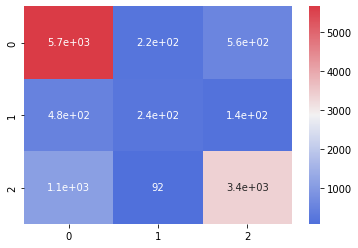

In [59]:
run_random_cv(estimator=clf_bc, hps=bc_hps, scoring='accuracy', X=X_res, y=y_res)

### Unbalanced Dataset

**XGBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 1e-05, 'n_estimators': 200, 'min_child_weight': 0.6, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
Best Score: 0.7866792929292931
-----------------------------------------
Accuracy: 0.7892255892255893
Precision: 0.7336493917050526
Recall: 0.6241879040685427
              precision    recall  f1-score   support

           0       0.77      0.90      0.83      6452
           1       0.59      0.24      0.34       863
           2       0.84      0.73      0.78      4565

    accuracy                           0.79     11880
   macro avg       0.73      0.62      0.65     11880
weighted avg       0.78      0.79      0.78     11880



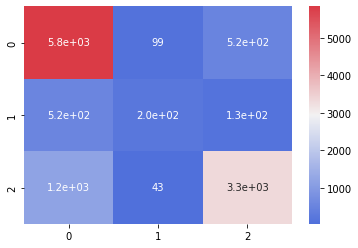

In [71]:
run_random_cv(estimator=clf_xgb, hps=xgb_hps, scoring='accuracy', X=X_train, y=y_train)

**CatBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'verbose': 0, 'random_strength': 1, 'learning_rate': 0.03, 'l2_leaf_reg': 5, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 8, 'border_count': 32, 'bagging_temperature': 0.5}
Best Score: 0.7853114478114479
-----------------------------------------
Accuracy: 0.7884680134680134
Precision: 0.7348916711112873
Recall: 0.618063433176508
              precision    recall  f1-score   support

           0       0.77      0.90      0.83      6452
           1       0.60      0.22      0.32       863
           2       0.83      0.73      0.78      4565

    accuracy                           0.79     11880
   macro avg       0.73      0.62      0.64     11880
weighted avg       0.78      0.79      0.78     11880



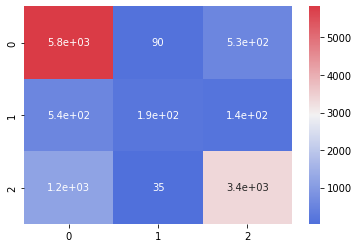

In [72]:
run_random_cv(estimator=clf_cb, hps=cb_hps, scoring='accuracy', X=X_train, y=y_train)

**HistGradientBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'validation_fraction': 0.1, 'n_iter_no_change': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_iter': 750, 'max_depth': 8, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 1.0, 'early_stopping': False}
Best Score: 0.7827020202020202
-----------------------------------------
Accuracy: 0.7867845117845118
Precision: 0.7085871939829652
Recall: 0.6311610522675023
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      6452
           1       0.52      0.26      0.35       863
           2       0.83      0.74      0.78      4565

    accuracy                           0.79     11880
   macro avg       0.71      0.63      0.65     11880
weighted avg       0.78      0.79      0.78     11880



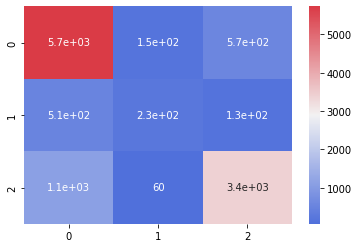

In [73]:
run_random_cv(estimator=clf_hgb, hps=hgb_hps, scoring='accuracy', X=X_train, y=y_train)

**Bagging Classifier**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': False}
Best Score: 0.7870159932659933
-----------------------------------------
Accuracy: 0.7904040404040404
Precision: 0.7273118649792178
Recall: 0.6176356901931254
              precision    recall  f1-score   support

           0       0.78      0.90      0.83      6452
           1       0.57      0.21      0.31       863
           2       0.83      0.74      0.79      4565

    accuracy                           0.79     11880
   macro avg       0.73      0.62      0.64     11880
weighted avg       0.78      0.79      0.78     11880



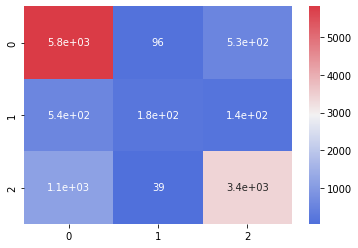

In [90]:
run_random_cv(estimator=clf_bc, hps=bc_hps, scoring='accuracy', X=X_train, y=y_train)

## Testing Features & Hyperparams

Once we have a list of possible features, and hyper-params with models. We will test out different combinations of hyperparams / ensemble models / feature lists.

In order to record each run, we will use weights & biases.

In [111]:
# This current set-up doesn't balanced the dataset, as I found there was not much need for it.

def run_wb(features, architecture, params, clf):
    wandb.init(
        project="DMA-project",
        entity="team-69",
        config={
            "features": features,
            "architecture": architecture,
            "params": params
        }
    )

    features = df[features]
    target = df['outcome']
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,
                                                        random_state=42, stratify=target)
    
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, average='macro')
    recall = recall_score(y_test, preds, average='macro')

    wandb.log({'acc':acc, 'precision':precision, 'recall':recall})

    wandb.finish()
    
    return acc, precision, recall



In [43]:
import random

In [41]:
# Take a random subset of features

possible_features = [['quantity'], ['waterpoint_type', 'waterpoint_type_group'],
                     ['extraction_type', 'extraction_type_group', 'extraction_type_class'],
                     ['payment', 'payment_type'], ['age'],
                     [('latitude_imputation', 'longitude_imputation'), ('longitude', 'latitude')],
                     ['zones'], ['season'], ['basin'], ['source', 'source_type', 'source_class'],
                     [('cat_funder', 'cat_installer'), ('funder_grouped', 'installer_grouped')],
                     ['consistent_water', 'source_below_sea_level'],
                     ['population_mean', 'population'], ['water_quality', 'quality_group'],
                     ['construction_decade'], ['gps_height_minmaxnormalised', 'gps_height_zscorenormalise']]

def gen_features(seed, n_features=15):
    random.seed(seed)
    features = []
    for feature in possible_features:
        nf = random.choice(feature)
        if type(nf) is tuple:
            features.append(nf[0])
            features.append(nf[1])
        else:
            features.append(nf)
    
    return random.sample(features, n_features)

In [151]:
# You can change this random seed to get a completely different set of results.
# All the results will be saved on weights & biases.
# For reference, we have used these seeds so far [42]
random.seed(24)

seeds = [random.randint(0, 1000) for i in range(20)]
architectures = ['XGBoost', 'CatBoost', 'HistGradBoost', 'Bagging']

# I'll take all the 'best' params from our previous HP tuning section.
xgb_params = [{'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 1e-05, 'n_estimators': 200, 'min_child_weight': 0.6, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7},
              {'subsample': 0.8, 'reg_lambda': 1e-05, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1}]
cb_params = [{'verbose': 0, 'random_strength': 1, 'learning_rate': 0.03, 'l2_leaf_reg': 5, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 8, 'border_count': 32, 'bagging_temperature': 0.5},
             {'verbose': 0, 'random_strength': 10, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 8, 'border_count': 32, 'bagging_temperature': 1.0}]
hgb_params = [{'validation_fraction': 0.1, 'n_iter_no_change': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_iter': 750, 'max_depth': 8, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 1.0, 'early_stopping': False}]
bc_params = [{'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': False},
             {'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': True},
             {'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap_features': False, 'bootstrap': False}]

for seed in seeds:
    features = gen_features(seed)
    architecture = random.choice(architectures)
    print(architecture)
    if architecture == 'XGBoost':
        params = random.choice(xgb_params)
        clf = XGBClassifier(**params)
        run_wb(features, architecture, params, clf)
    elif architecture == 'CatBoost':
        params = random.choice(cb_params)
        clf = CatBoostClassifier(**params)
        run_wb(features, architecture, params, clf)
    elif architecture == 'HistGradBoost':
        params = random.choice(hgb_params)
        clf = HistGradientBoostingClassifier(**params)
        run_wb(features, architecture, params, clf)
    elif architecture == 'Bagging':
        params = random.choice(bc_params)
        clf = BaggingClassifier(**params)
        run_wb(features, architecture, params, clf)
    else:
        print("If you see this, it's too late....")
    
    

CatBoost


acc,▁
precision,▁
recall,▁
acc,0.79335
precision,0.73652
recall,0.62793


HistGradBoost


acc,▁
precision,▁
recall,▁
acc,0.80286
precision,0.73216
recall,0.66157


XGBoost


acc,▁
precision,▁
recall,▁
acc,0.78662
precision,0.74001
recall,0.62611


CatBoost


acc,▁
precision,▁
recall,▁
acc,0.79554
precision,0.745
recall,0.62888


XGBoost


acc,▁
precision,▁
recall,▁
acc,0.79992
precision,0.71561
recall,0.66087


CatBoost


acc,▁
precision,▁
recall,▁
acc,0.75185
precision,0.70767
recall,0.59263


Bagging


acc,▁
precision,▁
recall,▁
acc,0.77374
precision,0.69715
recall,0.62837


HistGradBoost


acc,▁
precision,▁
recall,▁
acc,0.80455
precision,0.73232
recall,0.65614


CatBoost


acc,▁
precision,▁
recall,▁
acc,0.79495
precision,0.74904
recall,0.62967


HistGradBoost


acc,▁
precision,▁
recall,▁
acc,0.80631
precision,0.73387
recall,0.66074


CatBoost


acc,▁
precision,▁
recall,▁
acc,0.77323
precision,0.71862
recall,0.61701


CatBoost


acc,▁
precision,▁
recall,▁
acc,0.79217
precision,0.70374
recall,0.64946


HistGradBoost


acc,▁
precision,▁
recall,▁
acc,0.80076
precision,0.73715
recall,0.65051


XGBoost


acc,▁
precision,▁
recall,▁
acc,0.79891
precision,0.73306
recall,0.63681


XGBoost


acc,▁
precision,▁
recall,▁
acc,0.78931
precision,0.73346
recall,0.62369


HistGradBoost


acc,▁
precision,▁
recall,▁
acc,0.80337
precision,0.72699
recall,0.6535


HistGradBoost


acc,▁
precision,▁
recall,▁
acc,0.80581
precision,0.73204
recall,0.66169


CatBoost


acc,▁
precision,▁
recall,▁
acc,0.78106
precision,0.68839
recall,0.6454


Bagging


acc,▁
precision,▁
recall,▁
acc,0.80017
precision,0.72034
recall,0.65472


Bagging


acc,▁
precision,▁
recall,▁
acc,0.8021
precision,0.73076
recall,0.65267


## Voting Classifier

As all of models perform similarily and neither gains a significant improvement in metrics over the other, perhaps we could combine them and see what happens?

In [64]:
voting_features = ['age', 'latitude_imputation', 'longitude_imputation', 'construction_decade',
                  'quality_group', 'basin', 'extraction_type', 'cat_installer', 'population',
                  'gps_height_zscorenormalise', 'cat_funder', 'quantity', 'consistent_water',
                  'source_class', 'zones', 'waterpoint_type', 'season', 'extraction_type_class',
                  'payment']

In [48]:
clf_cb = CatBoostClassifier(bagging_temperature=0.5, border_count=32, depth=8, grow_policy='Depthwise',
                           iterations=1000, l2_leaf_reg=5, learning_rate=0.03, random_strength=1, verbose=0)
clf_xgb = XGBClassifier(colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=9, min_child_weight=1,
                        n_estimators=200, reg_alpha=1, reg_lambda=0.00001, subsample=0.8)
clf_hgb = HistGradientBoostingClassifier(early_stopping=False, l2_regularization=1, learning_rate=0.05, max_bins=255,
                                        max_depth=8, max_iter=750, max_leaf_nodes=None, min_samples_leaf=5, n_iter_no_change=5,
                                        validation_fraction=0.1)
clf_bag = BaggingClassifier(bootstrap=True, bootstrap_features=True, max_features=1, max_samples=1, n_estimators=100,
                           n_jobs=-1, warm_start=True)

In [49]:
from sklearn.ensemble import VotingClassifier

In [65]:
features = df[voting_features]
target = df['outcome']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [78]:
voting_clf = VotingClassifier(estimators=[('catboost',clf_cb), ('xgboost', clf_xgb), ('hgb', clf_hgb), ('Bagging', clf_bag)], voting='soft')

In [79]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7f9d644c0100>),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0,
                                            gpu_id=None, grow_policy=None,
                                            importance_t...
                                            reg_alpha=1, reg_lambda=1e-05, ...)),
                             ('hgb',
                              HistGradientBoostingClassifier(early_stopping=False,
                                                             l2_regularization=1,
                                                             learning_rate=0.05,
                                                             max_depth=8,
                                                             max_iter=750,
                                                             max_leaf_nodes=None,
                                                             min_samples_leaf=5,
                                                             n_iter_no_change=5)),
                             ('Bagging',
                              BaggingClassifier(bootstrap_features=True,
                                                max_features=1, max_samples=1,
                                                n_estimators=100, n_jobs=-1,
                                                warm_start=True))],
                 voting='soft')

In [84]:
prob_preds = voting_clf.predict_proba(X_test)

In [85]:
preds = np.argmax(prob_preds, axis=1)

In [89]:
accuracy_score(y_test, preds)

0.8111952861952862

In [92]:
recall_score(y_test, preds, average='macro')

0.652716998060621

If we were to train each model on slightly different subsets of the data (bagging), then we would have some variance and this would improve our voting classifier.

To do this, we need to write our own custom classifier - which would have a list of models trained on subsets.

In [136]:
class CustomVotingClassifier():
    
    def __init__(self, estimators, bagging=True):
        """
        Args:
            estimators ([(string, Classifier)]): A list of tuples containing the label and estimator itself.
        """
        self.estimators_ = [est[1] for est in estimators]
        self.estimators = estimators
        self.bagging = bagging
    
    def fit(self, X, y):
        
        if self.bagging:
            concat_df = pd.concat([X, y], axis=1)
        
        for est in self.estimators_:
            if self.bagging:
                sampled_data = concat_df.sample(n=len(concat_df), replace=True)
                new_X = sampled_data.drop('outcome', axis=1)
                new_y = sampled_data['outcome']
                
                est.fit(new_X, new_y)
            else:
                est.fit(X, y)
    
    def predict(self, X):
        
        preds_proba = np.asarray([est.predict_proba(X) for est in self.estimators_])
        avg = np.average(preds_proba, axis=0)
        
        preds = np.argmax(avg, axis=1)
        return preds
        
                
            
            

In [137]:
custom_voting = CustomVotingClassifier(estimators=[('catboost',clf_cb), ('xgboost', clf_xgb), ('hgb', clf_hgb), ('Bagging', clf_bag)])

In [138]:
custom_voting.fit(X_train, y_train)

/home/tcotts/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


In [140]:
preds = custom_voting.predict(X_test)

In [141]:
accuracy_score(y_test, preds)

0.8047979797979798

In [142]:
recall_score(y_test, preds, average='macro')

0.6363343869769466

### Saving the model

We can save our best model for later use.

In [44]:
import pickle

In [45]:
with open("./models/XGB.pickle", "wb") as f:
    pickle.dump(random_cv.best_estimator_, f)